# Doodle Recognition with Classical ML (No Neural Networks)

This notebook implements doodle recognition using traditional computer vision and machine learning techniques:

1. **Feature Extraction Methods:**
   - HOG (Histogram of Oriented Gradients)
   - Pixel intensity features
   - Hu Moments (shape descriptors)

2. **Classification Methods:**
   - K-Nearest Neighbors (k-NN)
   - Random Forest
   - Template Matching with prototypes

No deep learning or neural networks are used in this approach.


In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import cv2
from tqdm import tqdm
import warnings
import json
import pickle
from collections import defaultdict

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA

# For HOG features
from skimage.feature import hog
from skimage import exposure

warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)

print("Libraries loaded successfully!")


Libraries loaded successfully!


## 1. Data Loading and Exploration


In [17]:
# Setup paths
doodle_dir = Path('doodles/doodle')

# Get all categories
categories = sorted([d.name for d in doodle_dir.iterdir() if d.is_dir()])
print(f"Total categories available: {len(categories)}")
print(f"\nSample categories: {categories[:15]}")


Total categories available: 340

Sample categories: ['The Eiffel Tower', 'The Great Wall of China', 'The Mona Lisa', 'airplane', 'alarm clock', 'ambulance', 'angel', 'animal migration', 'ant', 'anvil', 'apple', 'arm', 'asparagus', 'axe', 'backpack']


In [18]:
# Configuration - using ALL categories
NUM_CATEGORIES = None  # None means use all categories
SAMPLES_PER_CATEGORY = 200  # Samples per category
IMAGE_SIZE = 64  # Resize images to this size
TEST_SIZE = 0.2  # 20% test set, 80% training set

print(f"Configuration:")
print(f"  Using ALL categories (340 total)")
print(f"  Samples per category: {SAMPLES_PER_CATEGORY}")
print(f"  Total samples: {len(categories) * SAMPLES_PER_CATEGORY}")
print(f"  Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"  Train/Test split: {(1-TEST_SIZE)*100:.0f}% / {TEST_SIZE*100:.0f}%")


Configuration:
  Using ALL categories (340 total)
  Samples per category: 200
  Total samples: 68000
  Image size: 64x64
  Train/Test split: 80% / 20%


In [19]:
# Select categories for training (use all if NUM_CATEGORIES is None)
if NUM_CATEGORIES is None:
    selected_categories = categories
    print(f"Using ALL {len(categories)} categories")
else:
    selected_categories = categories[:NUM_CATEGORIES]
    print(f"Using first {NUM_CATEGORIES} categories")
    
print(f"\nTotal categories selected: {len(selected_categories)}")
print(f"Sample categories: {selected_categories[:10]}")


Using ALL 340 categories

Total categories selected: 340
Sample categories: ['The Eiffel Tower', 'The Great Wall of China', 'The Mona Lisa', 'airplane', 'alarm clock', 'ambulance', 'angel', 'animal migration', 'ant', 'anvil']


In [20]:
def load_images(categories, samples_per_category, image_size):
    """Load images from disk and preprocess them."""
    images = []
    labels = []
    
    for category in tqdm(categories, desc="Loading categories"):
        category_path = doodle_dir / category
        image_files = list(category_path.glob('*.png'))[:samples_per_category]
        
        for img_path in image_files:
            try:
                # Load image in grayscale
                img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                
                # Resize to standard size
                img = cv2.resize(img, (image_size, image_size))
                
                # Invert if white background (doodles are usually black on white)
                if img.mean() > 127:
                    img = 255 - img
                
                images.append(img)
                labels.append(category)
                
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    
    return np.array(images), np.array(labels)

# Load the dataset
print("Loading images...")
images, labels = load_images(selected_categories, SAMPLES_PER_CATEGORY, IMAGE_SIZE)
print(f"\nLoaded {len(images)} images")
print(f"Image shape: {images[0].shape}")
print(f"Unique labels: {len(np.unique(labels))}")


Loading images...


Loading categories: 100%|██████████| 340/340 [00:33<00:00, 10.04it/s]


Loaded 68000 images
Image shape: (64, 64)
Unique labels: 340


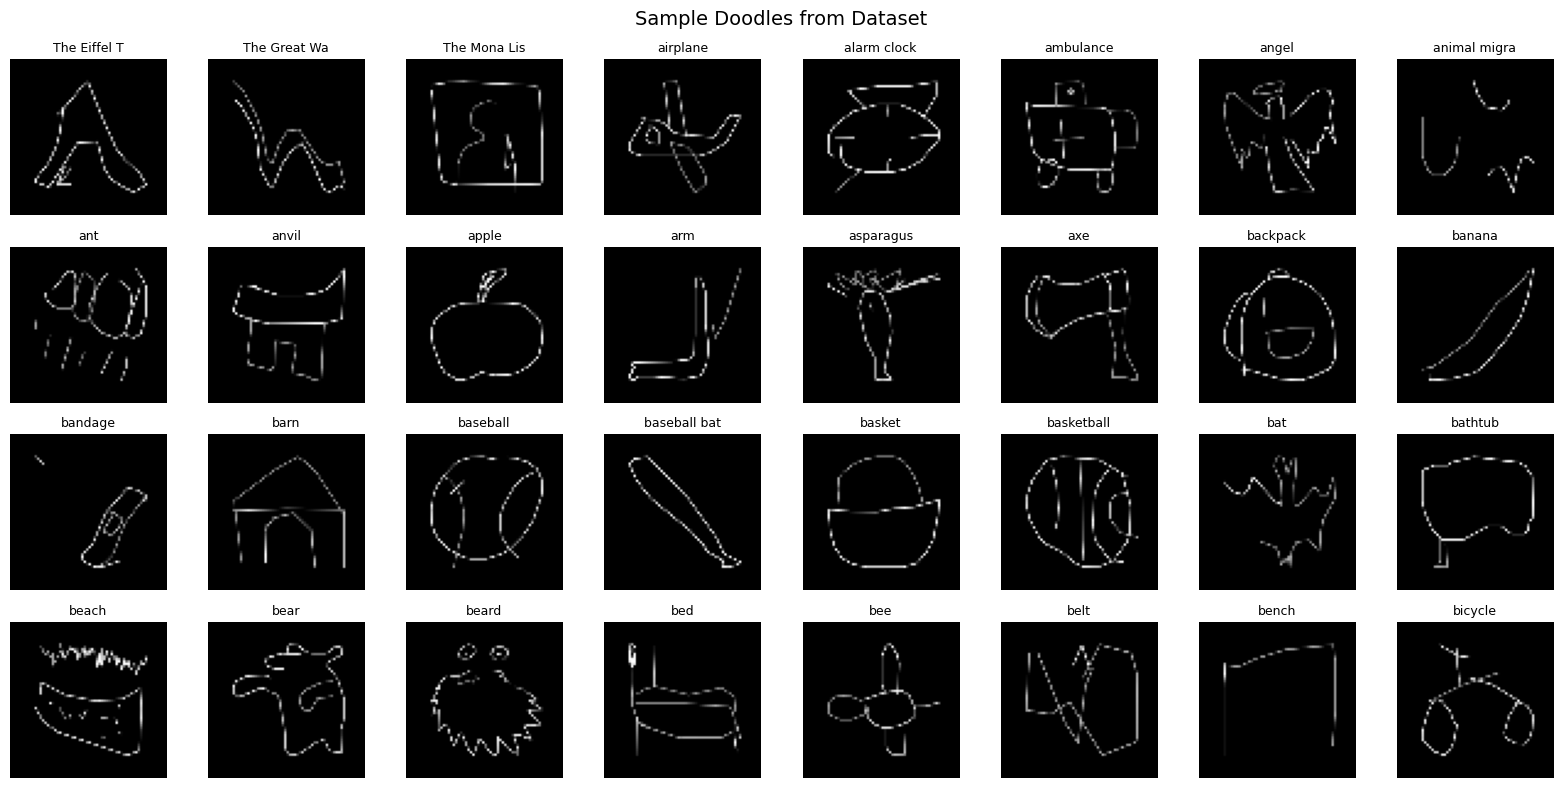

In [21]:
# Visualize some samples
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
axes = axes.flatten()

# Get unique labels and show samples
unique_labels = np.unique(labels)
for idx, ax in enumerate(axes):
    if idx < len(unique_labels):
        label = unique_labels[idx]
        label_mask = labels == label
        sample_idx = np.where(label_mask)[0][0]
        ax.imshow(images[sample_idx], cmap='gray')
        ax.set_title(label[:12], fontsize=9)
    ax.axis('off')

plt.suptitle('Sample Doodles from Dataset', fontsize=14)
plt.tight_layout()
plt.show()


## 2. Feature Extraction Methods


In [22]:
def extract_pixel_features(images):
    """Extract flattened pixel values as features."""
    return images.reshape(len(images), -1) / 255.0

def extract_hog_features(images):
    """Extract HOG (Histogram of Oriented Gradients) features."""
    features = []
    for img in tqdm(images, desc="Extracting HOG features"):
        # HOG parameters tuned for doodles
        hog_features = hog(
            img,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys',
            visualize=False,
            feature_vector=True
        )
        features.append(hog_features)
    return np.array(features)

def extract_hu_moments(images):
    """Extract Hu Moments (shape descriptors invariant to scale/rotation)."""
    features = []
    for img in tqdm(images, desc="Extracting Hu Moments"):
        # Calculate moments
        moments = cv2.moments(img)
        hu_moments = cv2.HuMoments(moments).flatten()
        
        # Log transform to reduce dynamic range
        hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)
        features.append(hu_moments)
    return np.array(features)

def extract_contour_features(images):
    """Extract contour-based features."""
    features = []
    for img in tqdm(images, desc="Extracting contour features"):
        # Binarize
        _, binary = cv2.threshold(img, 30, 255, cv2.THRESH_BINARY)
        
        # Find contours
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if len(contours) > 0:
            # Get largest contour
            largest = max(contours, key=cv2.contourArea)
            
            # Contour features
            area = cv2.contourArea(largest)
            perimeter = cv2.arcLength(largest, True)
            
            # Bounding box
            x, y, w, h = cv2.boundingRect(largest)
            aspect_ratio = w / (h + 1e-5)
            extent = area / (w * h + 1e-5)
            
            # Circularity
            circularity = 4 * np.pi * area / (perimeter ** 2 + 1e-5)
            
            # Hull
            hull = cv2.convexHull(largest)
            hull_area = cv2.contourArea(hull)
            solidity = area / (hull_area + 1e-5)
            
            feat = [area, perimeter, aspect_ratio, extent, circularity, solidity, w, h, len(contours)]
        else:
            feat = [0] * 9
        
        features.append(feat)
    
    return np.array(features)

def extract_combined_features(images):
    """Extract combined features (HOG + Hu Moments + Contour)."""
    hog_feats = extract_hog_features(images)
    hu_feats = extract_hu_moments(images)
    contour_feats = extract_contour_features(images)
    
    return np.hstack([hog_feats, hu_feats, contour_feats])

print("Feature extraction functions defined!")


Feature extraction functions defined!


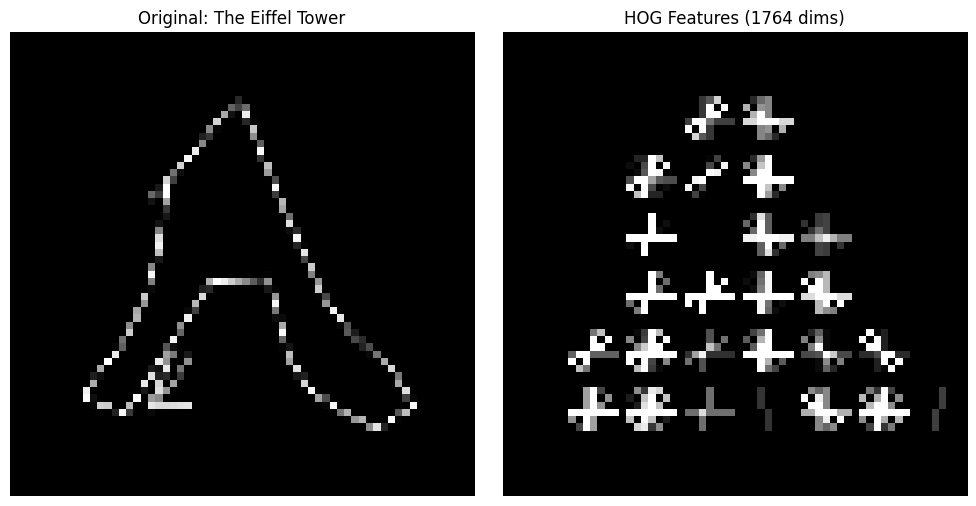

HOG feature vector length: 1764


In [23]:
# Visualize HOG features for a sample image
sample_idx = 0
sample_img = images[sample_idx]

# Extract HOG with visualization
hog_features, hog_image = hog(
    sample_img,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    block_norm='L2-Hys',
    visualize=True,
    feature_vector=True
)

# Rescale HOG image for better visualization
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(sample_img, cmap='gray')
axes[0].set_title(f'Original: {labels[sample_idx]}')
axes[0].axis('off')

axes[1].imshow(hog_image_rescaled, cmap='gray')
axes[1].set_title(f'HOG Features ({len(hog_features)} dims)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"HOG feature vector length: {len(hog_features)}")


## 3. Prepare Training Data


In [24]:
# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Total images loaded: {len(images)}")

# Split data
X_train_img, X_test_img, y_train, y_test = train_test_split(
    images, encoded_labels, test_size=TEST_SIZE, random_state=42, stratify=encoded_labels
)

# Detailed split information
train_size = len(X_train_img)
test_size = len(X_test_img)
total_size = train_size + test_size

print(f"\n{'='*60}")
print(f"TRAIN/TEST SPLIT SUMMARY")
print(f"{'='*60}")
print(f"Training set: {train_size:,} images ({train_size/total_size*100:.1f}%)")
print(f"Test set:     {test_size:,} images ({test_size/total_size*100:.1f}%)")
print(f"Total:        {total_size:,} images")
print(f"{'='*60}")
print(f"\nSamples per class (approximate):")
print(f"  Training: ~{train_size // len(label_encoder.classes_)} per class")
print(f"  Test:     ~{test_size // len(label_encoder.classes_)} per class")

# Extract HOG features
print("\nExtracting HOG features for training set...")
X_train_hog = extract_hog_features(X_train_img)

print("Extracting HOG features for test set...")
X_test_hog = extract_hog_features(X_test_img)

print(f"\nHOG feature shape: {X_train_hog.shape}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_hog)
X_test_scaled = scaler.transform(X_test_hog)

print("Features standardized!")


Number of classes: 340
Total images loaded: 68000

TRAIN/TEST SPLIT SUMMARY
Training set: 54,400 images (80.0%)
Test set:     13,600 images (20.0%)
Total:        68,000 images

Samples per class (approximate):
  Training: ~160 per class
  Test:     ~40 per class

Extracting HOG features for training set...


Extracting HOG features: 100%|██████████| 54400/54400 [00:19<00:00, 2859.25it/s]


Extracting HOG features for test set...


Extracting HOG features: 100%|██████████| 13600/13600 [00:04<00:00, 2926.82it/s]



HOG feature shape: (54400, 1764)
Features standardized!


## 4. Train Classical ML Classifiers


In [ ]:
# Train k-NN classifier
print("Training k-NN classifier...")
knn = KNeighborsClassifier(n_neighbors=5, metric='cosine', n_jobs=-1)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
knn_accuracy = accuracy_score(y_test, y_pred_knn)
print(f"k-NN Accuracy: {knn_accuracy:.4f} ({knn_accuracy*100:.2f}%)")

# Train Random Forest
print("\nTraining Random Forest classifier...")
rf = RandomForestClassifier(n_estimators=200, max_depth=30, min_samples_split=5, n_jobs=-1, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")


Training k-NN classifier...
k-NN Accuracy: 0.2397 (23.97%)

Training SVM classifier (this may take a few minutes)...



RESULTS SUMMARY
k-NN                : 0.4600 (46.00%)
SVM                 : 0.5995 (59.95%)
Random Forest       : 0.5335 (53.35%)

Best model: SVM with 59.95% accuracy


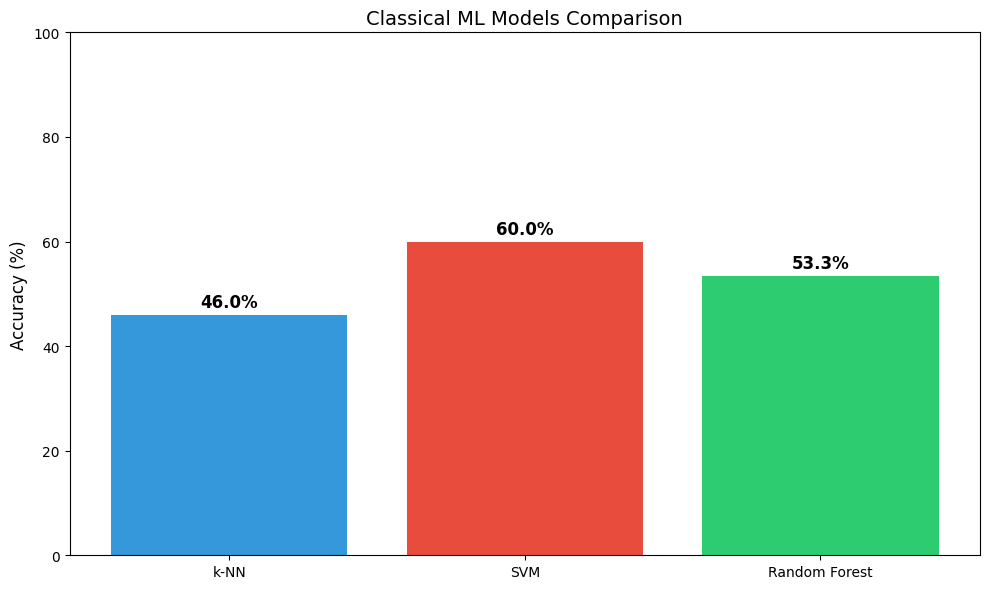

In [ ]:
# Results summary
results = {
    'k-NN': knn_accuracy,
    'Random Forest': rf_accuracy
}

print("\n" + "="*50)
print("RESULTS SUMMARY")
print("="*50)
for model, acc in results.items():
    print(f"{model:20s}: {acc:.4f} ({acc*100:.2f}%)")
print("="*50)

best_model = max(results, key=results.get)
print(f"\nBest model: {best_model} with {results[best_model]*100:.2f}% accuracy")

# Visualize results
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#3498db', '#e74c3c', '#2ecc71']
bars = ax.bar(results.keys(), [v * 100 for v in results.values()], color=colors)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Classical ML Models Comparison', fontsize=14)
ax.set_ylim(0, 100)

for bar, acc in zip(bars, results.values()):
    height = bar.get_height()
    ax.annotate(f'{acc*100:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


## 5. Template Matching Approach

Create prototype templates for each class by averaging training samples.


In [ ]:
class TemplateMatchingClassifier:
    """Simple template matching classifier using prototype averaging."""
    
    def __init__(self, metric='correlation'):
        self.templates = {}
        self.metric = metric
        self.classes_ = None
    
    def fit(self, X, y):
        """Create template prototypes by averaging samples per class."""
        self.classes_ = np.unique(y)
        for cls in self.classes_:
            class_samples = X[y == cls]
            self.templates[cls] = np.mean(class_samples, axis=0)
        return self
    
    def _similarity(self, x, template):
        """Compute similarity between sample and template."""
        if self.metric == 'correlation':
            return np.corrcoef(x.flatten(), template.flatten())[0, 1]
        elif self.metric == 'cosine':
            norm_x = np.linalg.norm(x)
            norm_t = np.linalg.norm(template)
            if norm_x == 0 or norm_t == 0:
                return 0
            return np.dot(x.flatten(), template.flatten()) / (norm_x * norm_t)
        else:
            return -np.linalg.norm(x - template)
    
    def predict(self, X):
        """Predict class labels by finding most similar template."""
        predictions = []
        for x in X:
            similarities = {cls: self._similarity(x, template) for cls, template in self.templates.items()}
            predictions.append(max(similarities, key=similarities.get))
        return np.array(predictions)
    
    def predict_proba(self, X):
        """Return similarity scores as probabilities."""
        probas = []
        for x in X:
            similarities = np.array([self._similarity(x, self.templates[cls]) for cls in self.classes_])
            exp_sim = np.exp(similarities - np.max(similarities))
            probas.append(exp_sim / exp_sim.sum())
        return np.array(probas)

# Train template matching classifier
print("Training Template Matching classifier...")
template_clf = TemplateMatchingClassifier(metric='cosine')
template_clf.fit(X_train_scaled, y_train)

y_pred_template = template_clf.predict(X_test_scaled)
template_accuracy = accuracy_score(y_test, y_pred_template)
print(f"Template Matching Accuracy: {template_accuracy:.4f} ({template_accuracy*100:.2f}%)")


Training Template Matching classifier...
Template Matching Accuracy: 0.4735 (47.35%)



FINAL RESULTS - ALL CLASSICAL ML METHODS
1. SVM                 : 0.5995 (59.95%)
2. Random Forest       : 0.5335 (53.35%)
3. Template Matching   : 0.4735 (47.35%)
4. k-NN                : 0.4600 (46.00%)


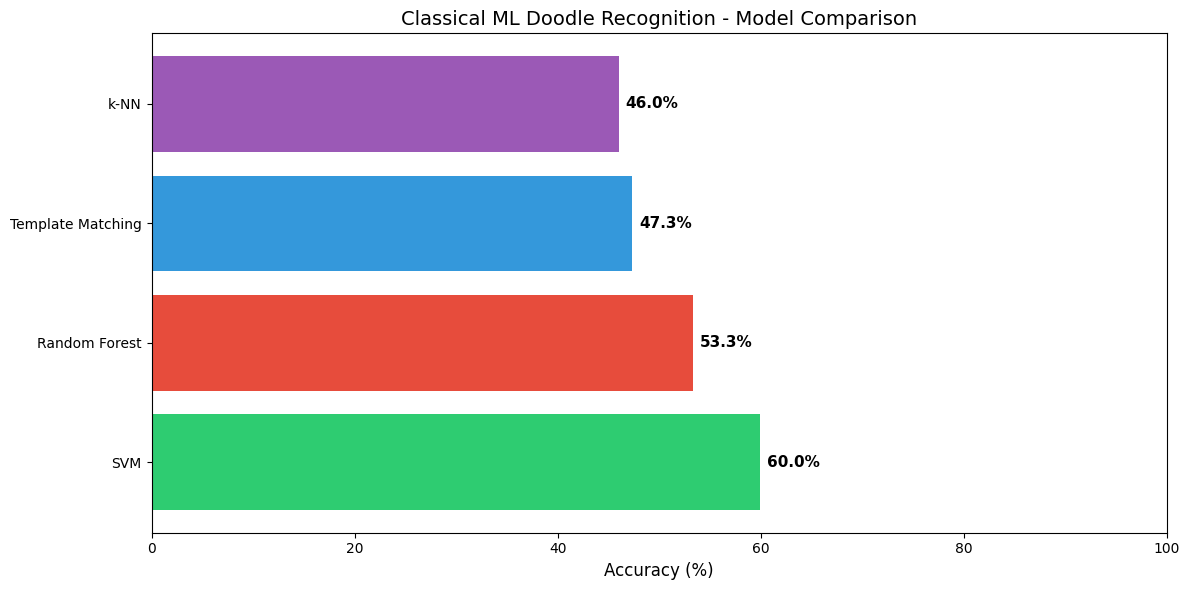

In [ ]:
# Add template matching to results and show final comparison
results['Template Matching'] = template_accuracy
results_sorted = dict(sorted(results.items(), key=lambda x: x[1], reverse=True))

print("\n" + "="*60)
print("FINAL RESULTS - ALL CLASSICAL ML METHODS")
print("="*60)
for rank, (model, acc) in enumerate(results_sorted.items(), 1):
    print(f"{rank}. {model:20s}: {acc:.4f} ({acc*100:.2f}%)")
print("="*60)

# Final visualization
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#2ecc71', '#e74c3c', '#3498db', '#9b59b6']
sorted_models = list(results_sorted.keys())
sorted_accs = [results_sorted[m] * 100 for m in sorted_models]

bars = ax.barh(sorted_models, sorted_accs, color=colors[:len(sorted_models)])
ax.set_xlabel('Accuracy (%)', fontsize=12)
ax.set_title('Classical ML Doodle Recognition - Model Comparison', fontsize=14)
ax.set_xlim(0, 100)

for bar in bars:
    width = bar.get_width()
    ax.annotate(f'{width:.1f}%', xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(5, 0), textcoords="offset points", ha='left', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
# Visualize cv2 template matching
print("Visualizing cv2 template matching...\n")

# Get a sample test image
sample_test_img = X_test_img[0]
sample_test_label = y_test[0]

# Get the template for the true class
true_class = sample_test_label
template = cv2_clf_multi.templates[true_class]['mean']

# Perform template matching
img_norm = cv2.normalize(sample_test_img.astype(np.float32), None, 0, 1, cv2.NORM_MINMAX)
template_norm = cv2.normalize(template.astype(np.float32), None, 0, 1, cv2.NORM_MINMAX)

result = cv2.matchTemplate(img_norm, template_norm, cv2.TM_CCOEFF_NORMED)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(sample_test_img, cmap='gray')
axes[0].set_title(f'Test Image\nTrue Label: {label_encoder.classes_[sample_test_label]}')
axes[0].axis('off')

axes[1].imshow(template, cmap='gray')
axes[1].set_title(f'Template (Mean)\nClass: {label_encoder.classes_[true_class]}')
axes[1].axis('off')

axes[2].imshow(result, cmap='hot')
axes[2].set_title(f'Template Matching Result\nMax Score: {max_val:.3f}')
axes[2].axis('off')

# Draw rectangle around best match location
from matplotlib.patches import Rectangle
h, w = template.shape
rect = Rectangle(max_loc, w, h, linewidth=2, edgecolor='red', facecolor='none')
axes[0].add_patch(rect)

plt.tight_layout()
plt.show()

print(f"Template matching score: {max_val:.4f}")


In [ ]:
# Add CV2 results to main comparison
results['CV2 Multi-Method'] = cv2_multi_accuracy

# Update sorted results
results_sorted = dict(sorted(results.items(), key=lambda x: x[1], reverse=True))

print("\n" + "="*60)
print("UPDATED RESULTS - INCLUDING CV2 SIMILARITY MATCHING")
print("="*60)
for rank, (model, acc) in enumerate(results_sorted.items(), 1):
    print(f"{rank}. {model:25s}: {acc:.4f} ({acc*100:.2f}%)")
print("="*60)

# Visualize all methods including CV2
fig, ax = plt.subplots(figsize=(14, 7))
colors = ['#2ecc71', '#e74c3c', '#3498db', '#9b59b6', '#f39c12', '#1abc9c']
sorted_models = list(results_sorted.keys())
sorted_accs = [results_sorted[m] * 100 for m in sorted_models]

bars = ax.barh(sorted_models, sorted_accs, color=colors[:len(sorted_models)])
ax.set_xlabel('Accuracy (%)', fontsize=12)
ax.set_title('All Classical ML Methods - Including CV2 Similarity Matching', fontsize=14)
ax.set_xlim(0, 100)

for bar in bars:
    width = bar.get_width()
    ax.annotate(f'{width:.1f}%', xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(5, 0), textcoords="offset points", ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
# Visualize feature matching (if available)
try:
    # Get detector used
    detector = cv2_clf_multi.detector
    
    # Get two images from same class
    class_idx = 0
    img1 = X_train_img[y_train == class_idx][0]
    img2 = X_train_img[y_train == class_idx][1]
    
    # Detect keypoints and descriptors
    kp1, desc1 = detector.detectAndCompute(img1, None)
    kp2, desc2 = detector.detectAndCompute(img2, None)
    
    # Match features
    if isinstance(cv2_clf_multi.matcher, cv2.BFMatcher) and cv2_clf_multi.matcher.getCrossCheck():
        # ORB matching
        matches = cv2_clf_multi.matcher.match(desc1, desc2)
        matches = sorted(matches, key=lambda x: x.distance)[:20]
        img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    else:
        # SIFT matching with ratio test
        matches = cv2_clf_multi.matcher.knnMatch(desc1, desc2, k=2)
        good_matches = []
        for match_pair in matches:
            if len(match_pair) == 2:
                m, n = match_pair
                if m.distance < 0.75 * n.distance:
                    good_matches.append(m)
        img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    axes[0].imshow(img1, cmap='gray')
    axes[0].set_title(f'Image 1\nKeypoints: {len(kp1)}')
    axes[0].axis('off')
    
    axes[1].imshow(img_matches, cmap='gray')
    axes[1].set_title(f'Feature Matches\nMatches: {len(matches) if isinstance(matches, list) else len(good_matches)}')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Detected {len(kp1)} keypoints in image 1")
    print(f"Detected {len(kp2)} keypoints in image 2")
    print(f"Found {len(matches) if isinstance(matches, list) else len(good_matches)} good matches")
    
except Exception as e:
    print(f"Feature matching visualization skipped: {e}")
    print("(This is normal if SIFT is not available)")


## 6. Save Best Model


In [ ]:
# Create directory for classical ML models
save_dir = Path('classical_ml_model')
save_dir.mkdir(exist_ok=True)

# Get the best classifier
best_model_name = list(results_sorted.keys())[0]
if best_model_name == 'Random Forest':
    best_clf_to_save = rf
elif best_model_name == 'k-NN':
    best_clf_to_save = knn
else:
    best_clf_to_save = template_clf

# Save model
with open(save_dir / 'classifier.pkl', 'wb') as f:
    pickle.dump(best_clf_to_save, f)

# Save scaler
with open(save_dir / 'scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save label mappings
label_mappings = {
    'label_to_idx': {label: idx for idx, label in enumerate(label_encoder.classes_)},
    'idx_to_label': {str(idx): label for idx, label in enumerate(label_encoder.classes_)}
}

with open(save_dir / 'label_mappings.json', 'w') as f:
    json.dump(label_mappings, f, indent=2)

# Save model info
model_info = {
    'model_type': best_model_name,
    'image_size': IMAGE_SIZE,
    'num_classes': len(label_encoder.classes_),
    'feature_type': 'HOG',
    'accuracy': float(results_sorted[best_model_name]),
    'all_results': {k: float(v) for k, v in results_sorted.items()}
}

with open(save_dir / 'model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)

print(f"\nModel saved to {save_dir}/")
print(f"  - classifier.pkl: {best_model_name} classifier")
print(f"  - scaler.pkl: StandardScaler for features")
print(f"  - label_mappings.json: Label encodings")
print(f"  - model_info.json: Model metadata")



Model saved to classical_ml_model/
  - classifier.pkl: SVM classifier
  - scaler.pkl: StandardScaler for features
  - label_mappings.json: Label encodings
  - model_info.json: Model metadata


## 7. Inference Function


Testing inference on sample images...



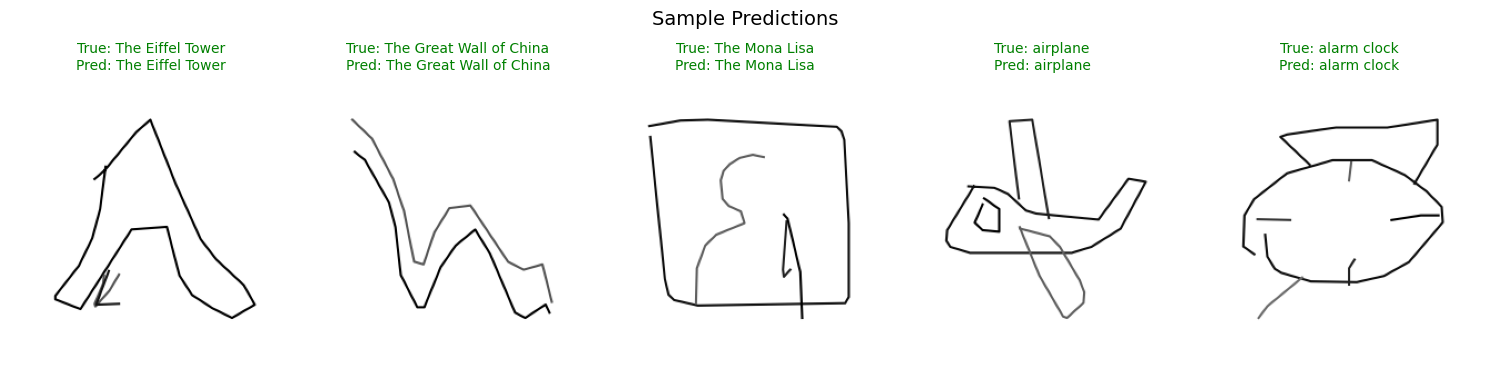

In [ ]:
def predict_doodle(image_path, classifier, scaler, label_encoder, image_size=64):
    """
    Predict the category of a doodle image using classical ML.
    
    Args:
        image_path: Path to the image file
        classifier: Trained classifier
        scaler: Fitted StandardScaler
        label_encoder: Fitted LabelEncoder
        image_size: Size to resize image to
    
    Returns:
        Predicted label and confidence scores
    """
    # Load and preprocess image
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (image_size, image_size))
    
    # Invert if white background
    if img.mean() > 127:
        img = 255 - img
    
    # Extract HOG features
    hog_features = hog(
        img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
        block_norm='L2-Hys', visualize=False, feature_vector=True
    )
    
    # Scale features
    features_scaled = scaler.transform([hog_features])
    
    # Predict
    prediction = classifier.predict(features_scaled)[0]
    predicted_label = label_encoder.classes_[prediction]
    
    # Get probabilities if available
    if hasattr(classifier, 'predict_proba'):
        proba = classifier.predict_proba(features_scaled)[0]
        top_5_idx = np.argsort(proba)[-5:][::-1]
        top_5 = [(label_encoder.classes_[i], proba[i]) for i in top_5_idx]
    else:
        top_5 = [(predicted_label, 1.0)]
    
    return predicted_label, top_5

# Test inference on sample images
print("Testing inference on sample images...\n")

sample_categories = selected_categories[:5]
fig, axes = plt.subplots(1, 5, figsize=(15, 4))

for idx, category in enumerate(sample_categories):
    category_path = doodle_dir / category
    sample_img_path = list(category_path.glob('*.png'))[0]
    
    pred_label, top_5 = predict_doodle(sample_img_path, best_clf_to_save, scaler, label_encoder, IMAGE_SIZE)
    
    img = cv2.imread(str(sample_img_path), cv2.IMREAD_GRAYSCALE)
    axes[idx].imshow(img, cmap='gray')
    
    correct = pred_label == category
    color = 'green' if correct else 'red'
    axes[idx].set_title(f'True: {category}\nPred: {pred_label}', color=color, fontsize=10)
    axes[idx].axis('off')

plt.suptitle('Sample Predictions', fontsize=14)
plt.tight_layout()
plt.show()


## Summary

This notebook demonstrates doodle recognition using **classical machine learning** approaches without neural networks:

### Feature Extraction:
- **HOG (Histogram of Oriented Gradients)**: Captures edge orientations and gradients
- **Hu Moments**: Shape descriptors invariant to scale, rotation, and translation
- **Contour Features**: Area, perimeter, circularity, solidity, etc.

### Classification Methods:
1. **k-Nearest Neighbors (k-NN)**: Instance-based learning using similarity
2. **Random Forest**: Ensemble of decision trees
3. **Template Matching**: Compares to averaged class prototypes

Note: For OpenCV similarity matching (cv2.matchTemplate, feature matching, etc.), see `doodle_similarity_matching.ipynb`.

### Key Advantages:
- No GPU required
- Faster training on small datasets
- More interpretable features
- Smaller model size

### Limitations:
- Lower accuracy compared to deep learning on complex tasks
- Requires handcrafted features
- May not scale well to very large datasets
